In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [66]:
actions = [
    'fall','stand'
]
data = np.load("dataset/raw_fall_0.npy")
datas = np.load("dataset/raw_stand_1.npy")

for i in range(1,800):
    data = np.concatenate([
        data,
        np.load(f'dataset/raw_fall_{i}.npy')
    ], axis=0)
    
for i in range(1,200):
    datas = np.concatenate([
        datas,
        np.load(f'dataset/raw_stand_{i}.npy')
    ], axis=0)
    
data = np.concatenate([data,datas])
print(data.shape)
print(datas.shape)

(1000, 30, 137)
(200, 30, 137)


In [67]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)
print(labels[700:1000])


(1000, 30, 136)
(1000,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [68]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1000, 2)

In [69]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(900, 30, 136) (900, 2)
(100, 30, 136) (100, 2)


In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                51456     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 53,602
Trainable params: 53,602
Non-trainable params: 0
_________________________________________________________________


In [71]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
28/29 [===========================>..] - ETA: 0s - loss: 2.4847 - acc: 0.7868
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models\model.h5
29/29 [==============================] - 1s 12ms/step - loss: 2.4737 - acc: 0.7878 - val_loss: 0.1331 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/200
28/29 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
29/29 [==============================] - 0s 7ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/200
28/29 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
29/29 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/200
28/29 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
29/29

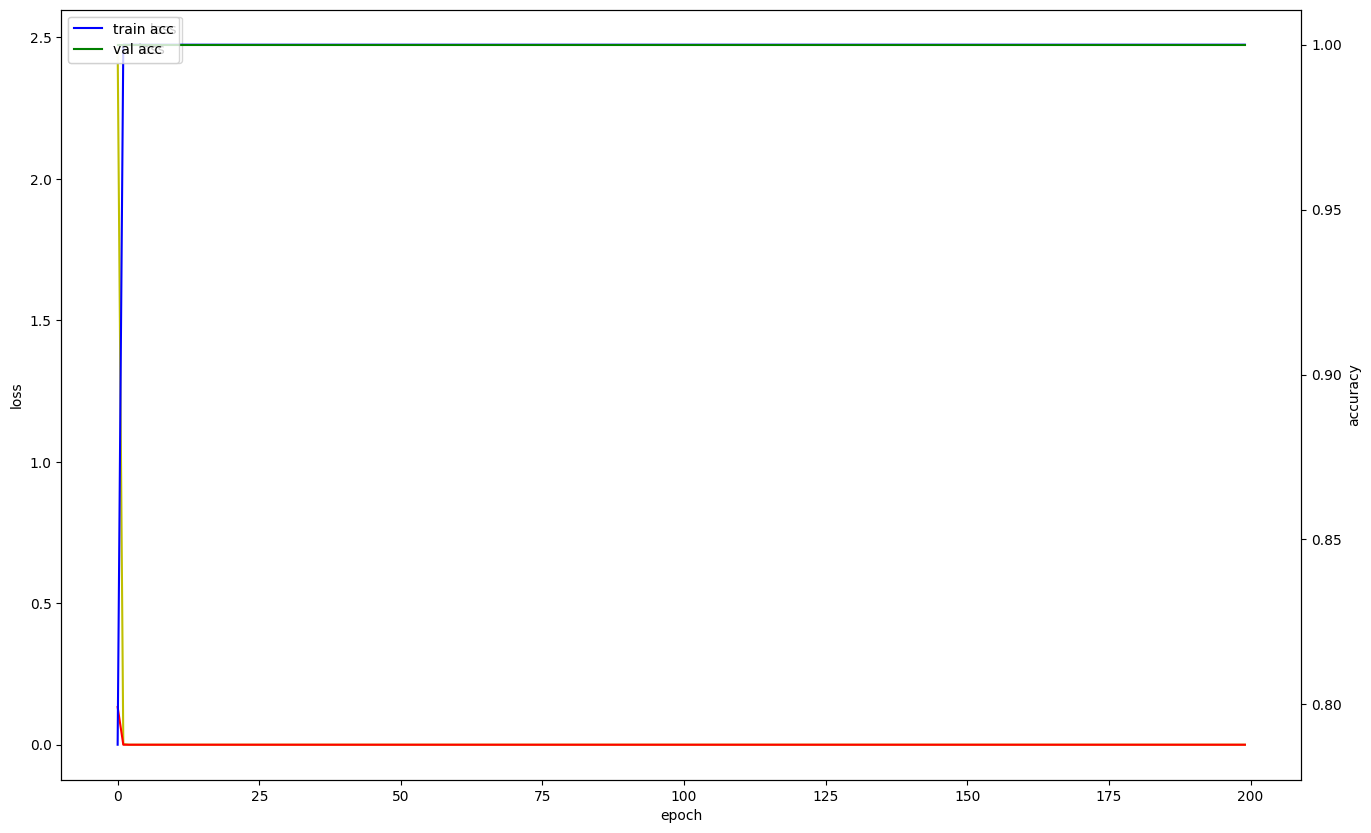

In [72]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [73]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

4/4 [==============================] - 0s 2ms/step


array([[[19,  0],
        [ 0, 81]],

       [[81,  0],
        [ 0, 19]]], dtype=int64)